## Cointegracion

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import coint, adfuller

import warnings
warnings.simplefilter("ignore")

In [54]:
dta = pd.read_excel("./Bases de datos/PeruData.xlsx", sheet_name="Trimestral", skiprows=1)
dta = dta[[
    'Trimestres', 'Producto bruto interno por tipo de gasto (millones S/ 2007) - PBI',
    'Producto bruto interno por tipo de gasto (millones S/ 2007) - Demanda Interna - Consumo Privado',
    'Producto bruto interno (millones de soles constantes de 2007) - Comercio',
    'Producto bruto interno (millones de soles constantes de 2007) - Servicios',
    'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)',
    'Liquidez de las sociedades creadoras de depósito (fin de periodo) - Circulante (millones S/)'
    ]]

dta.rename({
    'Producto bruto interno por tipo de gasto (millones S/ 2007) - PBI': 'PBI',
    'Producto bruto interno por tipo de gasto (millones S/ 2007) - Demanda Interna - Consumo Privado': 'Consumo_privado',
    'Producto bruto interno (millones de soles constantes de 2007) - Comercio': 'Comercio',
    'Producto bruto interno (millones de soles constantes de 2007) - Servicios': 'Servicio',
    'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)': 'IPC',
    'Liquidez de las sociedades creadoras de depósito (fin de periodo) - Circulante (millones S/)': 'Circulante'
    }, axis=1, inplace=True)

dta.index = pd.period_range("1980Q1", "2022Q2", freq="Q")

dta.to_excel("./Bases de datos/data_coint.xlsx", index=True)
dta = pd.read_excel("./Bases de datos/data_coint.xlsx", index_col="Unnamed: 0").drop("Trimestres", axis=1)
dta = dta.dropna()

In [55]:
# Creacion de indices 2021=100
dta["PBI"] = (dta["PBI"]/ dta["PBI"][dta["PBI"].index.get_level_values(0) == '2021'].mean() )*100
dta["Consumo_privado"] = (dta["Consumo_privado"]/ dta["Consumo_privado"][dta["Consumo_privado"].index.get_level_values(0) == '2021'].mean() )*100
dta["Comercio"] = (dta["Comercio"]/ dta["Comercio"][dta["Comercio"].index.get_level_values(0) == '2021'].mean() )*100
dta["Servicio"] = (dta["Servicio"]/ dta["Servicio"][dta["Servicio"].index.get_level_values(0) == '2021'].mean() )*100
dta["IPC"] = (dta["IPC"]/ dta["IPC"][dta["IPC"].index.get_level_values(0) == '2021'].mean() )*100
dta["Circulante"] = (dta["Circulante"]/ dta["Circulante"][dta["Circulante"].index.get_level_values(0) == '2021'].mean() )*100

#### Test de cointegracion
Se puede testear la presencia de cointegracion entre variables. De manera preliminar, se puede esperar que las siguientes relaciones de cointegracion:
* PBI y Consumo privado
* PBI comercio y PBI servicio
* IPC y Circulante

Para poder tener una relacion de cointegracion es necesario que ambas series sean raiz unitarias y estacionarias en sus primeras diferencias. Luego, la combinacion lineal (e.g. el residuo de un modelo con ambas) debe ser estacionaria

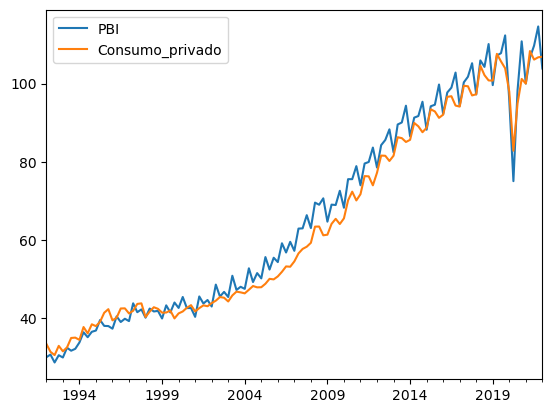

In [56]:
dta[["PBI", "Consumo_privado"]].plot()

plt.show()

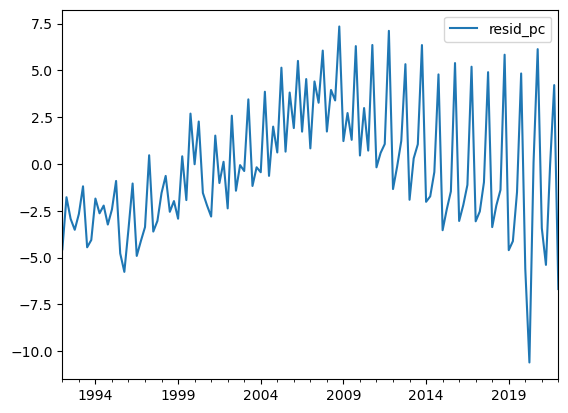

In [57]:
model = sm.OLS(dta["PBI"], dta["Consumo_privado"]).fit()
dta["resid_pc"] = dta["PBI"] - dta["Consumo_privado"]*model.params[0]

dta[["resid_pc"]].plot()
plt.show()

Se rechaza raiz unitaria en los residuos entre el PBI y el consumo privado con 1% de significancia, por lo tanto hay cointegracion

In [58]:
adf = adfuller(dta["resid_pc"], maxlag=1)
print(adf[0])
print("")
print(adf[4])

-8.636981591917353

{'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}


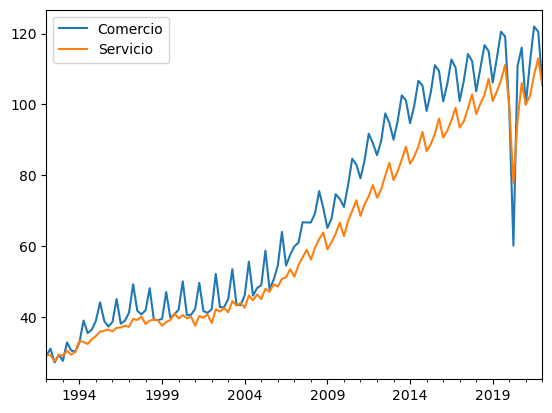

In [59]:
dta[["Comercio", "Servicio"]].plot()

plt.show()

Para el caso del PBI comercio y servicio si hay cointegracion

In [60]:
model = sm.OLS(dta["Comercio"], dta["Servicio"]).fit()
dta["resid_cs"] = dta["Comercio"] - dta["Servicio"]*model.params[0]

adf = adfuller(dta["resid_cs"], maxlag=1)
print(adf[0])
print("")
print(adf[4])

-7.571468226001186

{'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}


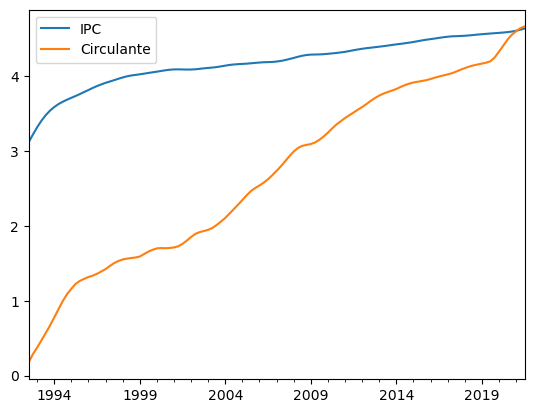

In [9]:
dta[["IPC", "Circulante"]].plot()

plt.show()

Finalmente, para el caso del IPC y circulante no parece haber cointegracion

In [61]:
model = sm.OLS(dta["IPC"], dta["Circulante"]).fit()
dta["resid_ic"] = dta["IPC"] - dta["Circulante"]*model.params[0]

adf = adfuller(dta["resid_ic"], maxlag=1)
print(adf[0])
print("")
print(adf[4])

1.9988521349550146

{'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}


### Estimacion por ECM

#### Referencias:
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.ardl.UECM.html#statsmodels.tsa.ardl.UECM